In [6]:
import os, pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

from hmmlearn.hmm import GaussianHMM

from matplotlib import cm, pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import YearLocator, MonthLocator
import seaborn as sns
sns.set()

from loaders import DataLoader
from strategies.hmm import StrategyHMM

In [7]:
# lighter version of dataloader without features

class DataLoader:
    '''The following class will be used to load the data and apply few initial filtering/preprocessing steps'''
    @classmethod
    def load(cls, asset: str,
             sampling: str = '1H',
             year_start: int = 2000,
             year_end: int = None):
        if os.path.exists(f'data/{asset}.csv'):
            data = pd.read_csv(f'data/{asset}.csv', header=None)
        else:
            raise FileNotFoundError('{asset}.csv was not found!')
        data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        data.iloc[:, 1:-1] /= 10e3
        data['Date'] = pd.to_datetime(data['Date'])
        if year_end is None:
            year_end = data['Date'].dt.year.unique()[-1]
        data = data[(data['Date'].dt.year >= year_start) & (data['Date'].dt.year <= year_end)]
        data.reset_index(inplace=True, drop=True)
        if sampling != '1H':
            data = cls._resample(data, sampling)
        # data = cls.featurise(data, sampling)
        data['ln_Close'] = np.log(data['Close'] / data['Close'].shift(1))
        # for each observation t add t+1 binary target
        data['target'] = np.sign(data['ln_Close'].shift(-1))
        # dropna from the last row
        data.dropna(inplace=True)
        # due to the nature of our data (only 2 decimal points) there are few occasions when close price is unchanged
        # replacing them with the previous target to keep it binary
        frac = round(data[data['target'] == 0].shape[0] / data.shape[0], 2)
        print(f'Warning: {frac} fraction of data has zero targets. Replacing it with previous target.')
        # data.loc[data['target'] == 0, 'target'] = 1
        data['target'] = data['target'].replace(to_replace=0, method='ffill')

        return data

    @staticmethod
    def _resample(data: pd.DataFrame, sampling):
        data.set_index('Date', inplace=True)
        data = data.resample(sampling).agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last'})
        data.dropna(inplace=True)
        data.reset_index(inplace=True)
        return data

In [15]:
df = DataLoader.load('ibm_trainval', sampling='1W', year_start=2000)

In [16]:
df.tail()

,Date,Open,High,Low,Close,ln_Close,target
860,2016-07-03,146.01,152.97,142.50,152.32,0.037798,1.0
861,2016-07-10,151.19,154.60,149.95,154.46,0.013952,1.0
862,2016-07-17,154.60,161.40,154.60,159.77,0.033800,1.0
863,2016-07-24,159.36,162.16,157.89,162.07,0.014293,-1.0
864,2016-07-31,162.00,163.60,160.03,160.63,-0.008925,1.0


In [17]:
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
hmm_model.fit(df['ln_Close'].to_numpy().reshape(-1, 1))
print("Model Score:", hmm_model.score(df['ln_Close'].to_numpy().reshape(-1, 1)))

Model Score: 1761.8270750948152


In [24]:
def plot_in_sample_hidden_states(hmm_model, df):
    hidden_states = hmm_model.predict(df['ln_Close'].to_numpy().reshape(-1, 1))
    fig, axs = plt.subplots(
        hmm_model.n_components,
        sharex=True, sharey=True,
        figsize=(10, 8)
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df['Date'][mask],
            df['Close'][mask],
            ".", 
            linestyle='none',
            c=colour)

        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
#         ax.grid(True)
    plt.savefig('HMM.jpg')
    plt.show()

    return hidden_states

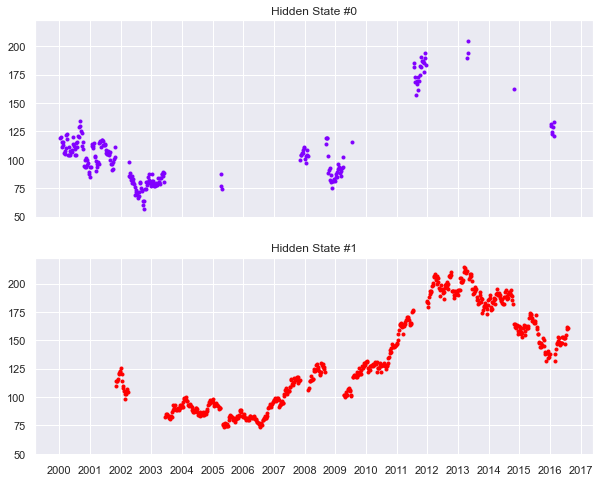

In [25]:
states = plot_in_sample_hidden_states(hmm_model, df)

In [76]:
chg = np.diff(states)
len(chg[chg != 0])

115

In [59]:
# df['state'] = [0] * df.shape[0]

In [63]:
strategy = StrategyHMM(2)
window = 52 * 2

In [64]:
predictions = [0] * window
for i, idx in enumerate(tqdm(range(df.shape[0] - window))):
    # slice the window
    X = df.iloc[idx:idx + window, :]
    strategy.fit(X)
    # define the state
#     df.loc[idx, 'state'] = strategy.predict(X)
    predictions.append(strategy.predict(X))
df['state'] = predictions

100%|██████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:49<00:00, 20.41it/s]


In [65]:
df['state'].sum() / df.shape[0]

0.42005420054200543

In [66]:
df['state'].value_counts()

0    642
1    465
Name: state, dtype: int64

In [74]:
df['Date_id'] = df['Date'].apply(lambda x: f'{x.year}_{x.isocalendar().week}')

In [78]:
with open('HMM2.pkl', 'wb') as f:
    pickle.dump(df, f)